Our model is forced by offline dynamics in 2002 for 6 times. This notebook displays our model results.

In [2]:
import netCDF4 as nc
import matplotlib.pyplot as plt
import numpy as np
import copy
import os
import glob
import pylab as pl
import numpy as np
import matplotlib.animation as animation
import types
from mpl_toolkits.basemap import cm,addcyclic,Basemap, shiftgrid
% matplotlib inline

nc_filename=sorted(glob.glob('/ocean/xiaoxiny/research/result_jasper/tracer6/newsms/fse3t_based_mask/*MIN*.nc'))#*_ptrc_T*.nc'))
print("found *.nc file: \n{}".format(nc_filename))

found *.nc file: 
['/ocean/xiaoxiny/research/result_jasper/tracer6/newsms/fse3t_based_mask/subset_MIN_ICE_1m_20020101_20031231.nc']


In [30]:
ptrc=nc.Dataset(nc_filename[0])

lon=ptrc.variables['nav_lon'][:]
lat=ptrc.variables['nav_lat'][:]
dep = ptrc.variables['deptht'][:]


Dsopt=nc.Dataset('/ocean/xiaoxiny/research/NEMO-code/NEMOGCM/CONFIG/myANHA/EXP00/data_Th_desorption_rate.nc')

bathy=nc.Dataset(
    '/ocean/xiaoxiny/research/data/Jasper/ANHA4_bathy_etopo1_gebco1_smoothed_coast_corrected_mar10.nc')
bathy=bathy.variables['Bathymetry'][400:,:]

minice=nc.Dataset(
    '/ocean/xiaoxiny/research/NEMO-code/NEMOGCM/CONFIG/myANHA/EXP00/dyn_off/ANHA4-EXH001_ice_y2002m09.nc')
minice=minice.variables['ileadfra'][:]

minice_=nc.Dataset(
    '/ocean/xiaoxiny/research/NEMO-code/NEMOGCM/CONFIG/myANHA/EXP00/Cryosphere2d_ANHA4-EXH001_icemod_y2001m09.nc')
minice_=minice_.variables['ileadfra'][:]

In [31]:
#Plot ice condition

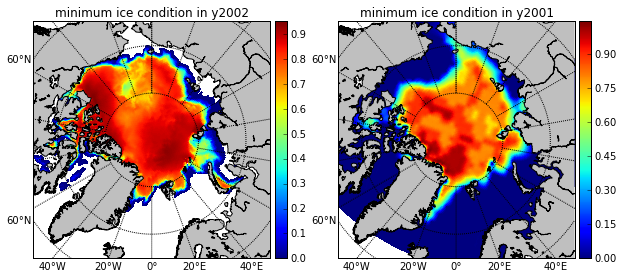

In [32]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,2,1)
m = Basemap(projection='npstere',boundinglat=65,lon_0=0,resolution='l')
m.drawcoastlines()
m.fillcontinents(color = '0.75')
m.drawparallels(np.arange(-80.,81.,10.),labels=[1, 0, 0, 0])
m.drawmeridians(np.arange(-180.,181.,20.),labels=[0, 0, 0, 1])
x_lon,y_lat = m(lon,lat)
m.pcolor(x_lon,y_lat,minice[0,400:,:]);m.colorbar()
plt.title('minimum ice condition in y2002')

ax = fig.add_subplot(1,2,2)
m = Basemap(projection='npstere',boundinglat=65,lon_0=0,resolution='l')
m.drawcoastlines()
m.fillcontinents(color = '0.75')
m.drawparallels(np.arange(-80.,81.,10.),labels=[1, 0, 0, 0])
m.drawmeridians(np.arange(-180.,181.,20.),labels=[0, 0, 0, 1])
x_lon,y_lat = m(lon,lat)
m.pcolor(x_lon,y_lat,minice_[400:,:]);m.colorbar()
plt.title('minimum ice condition in y2001')
plt.show()

In [3]:
#take a look at the time dimension
diss=ptrc.variables['TR_7'][:,0,0,0]
tlen=diss.shape
print tlen[0]

19


### Focus on the time evolution

In [88]:
def readdata(phase,string,i,x,y):
    if string =='Pa':
        if phase =='diss':
            data=ptrc.variables['TR_7'][:,i,x,y]
        else:
            data=ptrc.variables['TR_9'][:,i,x,y]
    else:
        if phase =='diss':
            data=ptrc.variables['TR_8'][:,i,x,y]
        else:
            data=ptrc.variables['TR_10'][:,i,x,y]
    data=np.ma.masked_where(data<=0,data)
    return data

def readice(string,i,x,y):
    if string =='Pa':
            data=ptrc.variables['TR_11'][:,i,x,y]
    else:
            data=ptrc.variables['TR_12'][:,i,x,y]
    if string =='deso':
        Dsopt=nc.Dataset('/ocean/xiaoxiny/research/NEMO-code/NEMOGCM/CONFIG/myANHA/EXP00/data_Th_desorption_rate.nc')
        data=Dsopt.variables['desorption_rate'][:,x,y]
    data=np.ma.masked_where(data<=0,data)
    return data

def analy(string,phase,i,loc,ice):
        if string=='Pa':
            k=0.02
            s=715.0*ice/ice
            k_1=0.8
            if phase=='part':
                analy=0.00246/s*dep[i]
            else:
                analy=0.00246/k+k_1/k*0.00246/s*dep[i]
        if string=='Th':
            k=-0.225*ice+0.2965
            s=715*ice/ice #in the model I used 1400, which shoule be corrected.
            if phase=='part':
                analy=0.0267/s*dep[i]
            else:
                k_1=readice('deso',i,x[loc],y[loc])
                analy=0.0267/k+k_1/k*0.0267/s*dep[i]
        return analy
                
def tracer_evolution(ptrc,j,string,name):
    

    
    fig = plt.figure(figsize=(20,10))
    gs = gridspec.GridSpec(3, 3)
    ax = fig.add_subplot(gs[0:2,0])
    m = Basemap(projection='npstere',boundinglat=65,lon_0=0,resolution='l')
    m.drawcoastlines()
    m.fillcontinents(color = '0.75')
    m.drawparallels(np.arange(-80.,81.,10.),labels=[1, 0, 0, 0])
    m.drawmeridians(np.arange(-180.,181.,20.),labels=[0, 0, 0, 1])
    x_lon,y_lat = m(lon,lat)
    plt.plot(x_lon[::10,::10],y_lat[::10,::10],x_lon.T[::10,::10],y_lat.T[::10,::10],color='k',linewidth=0.1)
    m.scatter(x_lon[x,y],y_lat[x,y],color=c,s=40)
    m = m.contour(x_lon,y_lat,bathy,linewidth=0.075,colors='black',alpha=0.4)
    plt.clabel(m, fontsize=10, inline=1,fmt = '%1.0f')

    ax = fig.add_subplot(gs[0,1])
    i=j[0]
    for loc in range (len(x)):
        data=readdata('diss',string,i,x[loc],y[loc])
        plt.plot(data,color=c[loc],linestyle='-',lw='2',label=('simulation'))
        ice=readice(string,i,x[loc],y[loc])
        ana=analy(string,'diss',i,loc,ice)
        plt.plot(ana,color=c[loc],linestyle='--',lw='2',label=('analytical'))
        #print ana
    plt.ylabel('Tracer concentration (dpm/m$^{3}$)')
    plt.title('%s'%(name[0]))
    ax.annotate('Depth: %sm'%dep[i], xy=(1, 0.8), xycoords='axes fraction', fontsize=11,
                xytext=(-5, 5), textcoords='offset points',
                ha='right', va='bottom')

    for num in range (tlen[0]/12):
        plt.axvline(x=(num+1)*12-1,ls=':')
    plt.xlim([0,tlen[0]-1])
    
    ax = fig.add_subplot(gs[0,2])      
    for loc in range (len(x)):
        data=readdata('part',string,i,x[loc],y[loc])
        plt.plot(data,color=c[loc],linestyle='-',lw='2',label=('analytical'))
        ice=readice(string,i,x[loc],y[loc])
        ana=analy(string,'part',i,loc,ice)
        #print ana
        plt.plot(ana,color=c[loc],linestyle='--',lw='2',label=('analytical'))
    plt.ylabel('Tracer concentration (dpm/m$^{3}$)')
    plt.title('%s'%(name[1]))
    ax.annotate('Depth: %sm'%dep[i], xy=(1, 0.8), xycoords='axes fraction', fontsize=11,
                xytext=(-5, 5), textcoords='offset points',
                ha='right', va='bottom')
    for num in range (tlen[0]/12):
        plt.axvline(x=(num+1)*12-1,ls=':')
    plt.xlim([0,tlen[0]-1])
    
    ax = fig.add_subplot(gs[1,1])
    i=j[1]
    for loc in range (len(x)):
        data=readdata('diss',string,i,x[loc],y[loc])
        plt.plot(data,color=c[loc],linestyle='-',lw='2',label=('simulation'))
        ice=readice(string,i,x[loc],y[loc])
        ana=analy(string,'diss',i,loc,ice)
        plt.plot(ana,color=c[loc],linestyle='--',lw='2',label=('analytical'),alpha=0.5)
    plt.ylabel('Tracer concentration (dpm/m$^{3}$)')
    ax.annotate('Depth: %sm'%dep[i], xy=(1, 0.8), xycoords='axes fraction', fontsize=11,
                xytext=(-5, 5), textcoords='offset points',
                ha='right', va='bottom')
    #plt.legend(loc=0,fontsize=11)
    for num in range (tlen[0]/12):
        plt.axvline(x=(num+1)*12-1,ls=':')
    plt.xlim([0,tlen[0]-1])

    ax = fig.add_subplot(gs[1,2])
    for loc in range (len(x)):
        data=readdata('part',string,i,x[loc],y[loc])
        plt.plot(data,color=c[loc],linestyle='-',lw='2',label=('simulation'))
        ice=readice(string,i,x[loc],y[loc])
        ana=analy(string,'part',i,loc,ice)
        plt.plot(ana,color=c[loc],linestyle='--',lw='2',label=('analytical'),alpha=0.5)
    plt.ylabel('Tracer concentration (dpm/m$^{3}$)')
    ax.annotate('Depth: %sm'%dep[i], xy=(1, 0.8), xycoords='axes fraction', fontsize=11,
                xytext=(-5, 5), textcoords='offset points',
                ha='right', va='bottom')
    #plt.legend(loc=0,fontsize=11)
    for num in range (tlen[0]/12):
        plt.axvline(x=(num+1)*12-1,ls=':')
    plt.xlim([0,tlen[0]-1])
    
    
    ax = fig.add_subplot(gs[2,1])
    i=j[2]
    for loc in range (len(x)):
        data=readdata('diss',string,i,x[loc],y[loc])
        plt.plot(data,color=c[loc],linestyle='-',lw='2',label=('simulation'))
        ice=readice(string,i,x[loc],y[loc])
        ana=analy(string,'diss',i,loc,ice)
        plt.plot(ana,color=c[loc],linestyle='--',lw='2',label=('analytical'),alpha=0.5)
    plt.xlabel('Time step (month)')
    plt.ylabel('Tracer concentration (dpm/m$^{3}$)')
    ax.annotate('Depth: %sm'%dep[i], xy=(1, 0.8), xycoords='axes fraction', fontsize=11,
                xytext=(-5, 5), textcoords='offset points',
                ha='right', va='bottom')
    #plt.legend(loc=0,fontsize=11)
    for num in range (tlen[0]/12):
        plt.axvline(x=(num+1)*12-1,ls=':')
    plt.xlim([0,tlen[0]-1])

    ax = fig.add_subplot(gs[2,2])
    for loc in range (len(x)):
        data=readdata('part',string,i,x[loc],y[loc])
        plt.plot(data,color=c[loc],linestyle='-',lw='2',label=('simulation'))
        ice=readice(string,i,x[loc],y[loc])
        ana=analy(string,'part',i,loc,ice)
        plt.plot(ana,color=c[loc],linestyle='--',lw='2',label=('analytical'),alpha=0.5)
    plt.xlabel('Time step (month)')
    plt.ylabel('Tracer concentration (dpm/m$^{3}$)')
    ax.annotate('Depth: %sm'%dep[i], xy=(1, 0.8), xycoords='axes fraction', fontsize=11,
                xytext=(-5, 5), textcoords='offset points',
                ha='right', va='bottom')
    for num in range (tlen[0]/12):
        plt.axvline(x=(num+1)*12-1,ls=':')
    plt.xlim([0,tlen[0]-1])
    #plt.legend(loc=0,fontsize=11)
    plt.show()

# 2002*6

The dash lines are analytical solutions. The solid lines are the model results.

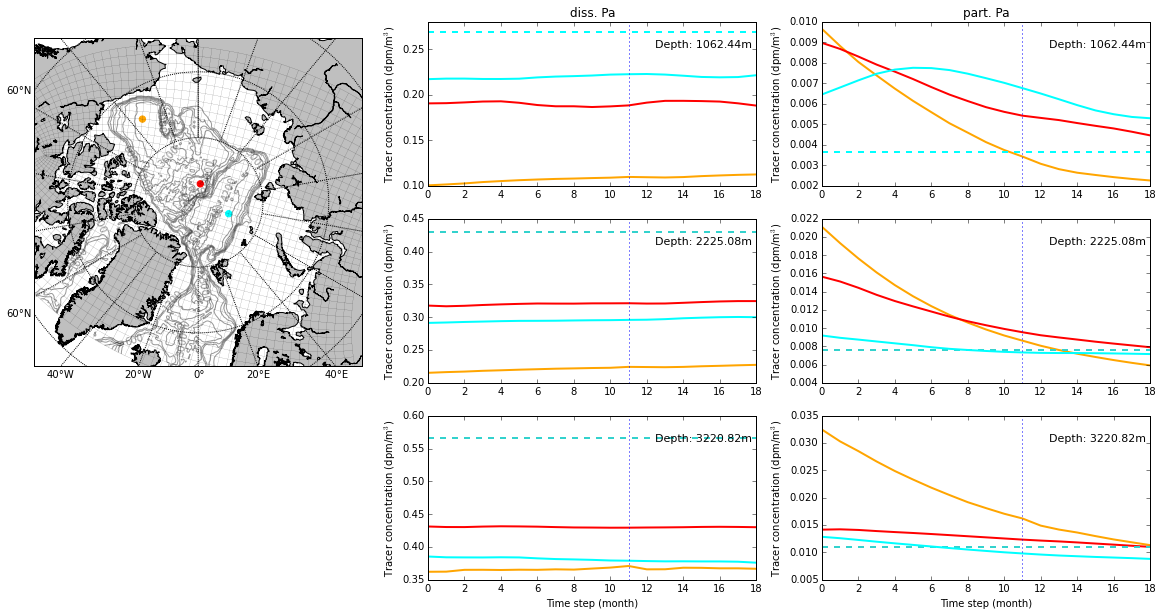

In [39]:
from matplotlib import gridspec
x=[700-400,630-400,600-400]
y=[200,300,350]
c=['orange','red','cyan']
ptrc=nc.Dataset(nc_filename[0])
tracer_evolution(ptrc,j=[35,40,43],string='Pa',name=['diss. Pa','part. Pa'])

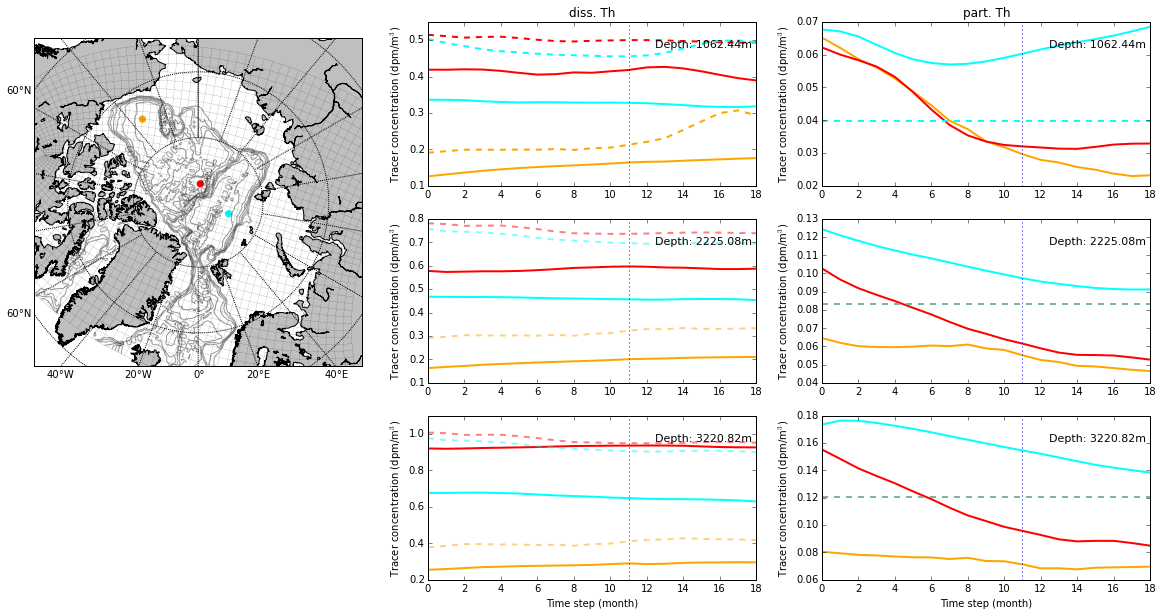

In [89]:
x=[700-400,630-400,600-400]
y=[200,300,350]
c=['orange','red','cyan']
ptrc=nc.Dataset(nc_filename[0])
tracer_evolution(ptrc,j=[35,40,43],string='Th',name=['diss. Th','part. Th'])

Advection? (similar trend for 3 different locations & can not tell from the distribution of Pa/th ratio

Scavenging?(are not getting close to the analytical solution)

Diffusion?


### Horiz. and Vert. Profiles

In [41]:
def readice(string,i,a1,a2,b1,b2):
    if string =='icePa':
            if i==0:
                data=ptrc.variables['TR_11'][:,:,a1:a2,b1:b2]
            else:
                data=ptrc.variables['TR_11'][:,i,a1:a2,b1:b2]
    else:

            if i==0:
                data=ptrc.variables['TR_12'][:,:,a1:a2,b1:b2]
            else:
                data=ptrc.variables['TR_12'][:,i,a1:a2,b1:b2]
    data=np.ma.masked_where(data<=0,data)
    return data

In [42]:
#write a function to read data
def readdata(phase,string,i,a1,a2,b1,b2):
    if string =='Pa':
        if phase =='diss':
            if i==0:
                data=ptrc.variables['TR_7'][:,:,a1:a2,b1:b2]
            else:
                data=ptrc.variables['TR_7'][:,i,a1:a2,b1:b2]
        else:
            if i==0:
                data=ptrc.variables['TR_9'][:,:,a1:a2,b1:b2]
            else:
                data=ptrc.variables['TR_9'][:,i,a1:a2,b1:b2]
    else:
        if phase =='diss':
            if i==0:
                data=ptrc.variables['TR_8'][:,:,a1:a2,b1:b2]
            else:
                data=ptrc.variables['TR_8'][:,i,a1:a2,b1:b2]
        else:
            if i==0:
                data=ptrc.variables['TR_10'][:,:,a1:a2,b1:b2]
            else:
                data=ptrc.variables['TR_10'][:,i,a1:a2,b1:b2]
    data=np.ma.masked_where(data<=0,data)
    return data

In [43]:
print tlen[0]/12

1


In [44]:
# write a function to plot data
def plot_ratio(string,title,data):
    fig = plt.figure(figsize=(20,20))

    for num in range (tlen[0]/12):
        ax1 = fig.add_subplot(5,3,num+1)
        #m = Basemap(projection='npstere',boundinglat=65,lon_0=0,resolution='l',ax=ax1)
        m = Basemap(width =3345532*1,height =950905*2.2,lon_0=-160, lat_0=75,
                        projection='stere', resolution='l',ax=ax1)
        m.drawcoastlines()
        m.fillcontinents(color = '0.75')
        m.drawparallels(np.arange(-80.,81.,10.),labels=[1, 0, 0, 0])
        m.drawmeridians(np.arange(-180.,181.,20.),labels=[0, 0, 0, 1])
        x_lon,y_lat = m(lon,lat)
        m.plot(x_lon[::10,::10],y_lat[::10,::10],x_lon.T[::10,::10],y_lat.T[::10,::10],color='k',linewidth=0.1)
        if num==0:
            im = m.pcolor(x_lon[a1:a2,b1:b2],y_lat[a1:a2,b1:b2],data[1,:,:],vmin=vmin,vmax=vmax)
        else:
            im = m.pcolor(x_lon[a1:a2,b1:b2],y_lat[a1:a2,b1:b2],data[(num+1)*12-1,:,:],vmin=vmin,vmax=vmax)

        plt.colorbar(im, ax = ax1, fraction=0.03,pad=0.02)
        x=[700-400,630-400,600-400]
        y=[200,300,350]
        c=['orange','red','cyan']
        m.scatter(x_lon[x,y],y_lat[x,y],c=c,s=40)
        plt.title('Horizontal profile for%s. %s (%s yr)'%(string,title,num),fontsize=10)

    plt.show()
    
    
def plot_ratio2(string,title,data):
    fig = plt.figure(figsize=(20,20))

    for num in range (tlen[0]/12):
        ax1 = fig.add_subplot(5,3,num+1)
        #m = Basemap(projection='npstere',boundinglat=65,lon_0=0,resolution='l',ax=ax1)
        m = Basemap(width =3345532*1,height =950905*2.2,lon_0=0, lat_0=85,
                        projection='stere', resolution='l',ax=ax1)
        m.drawcoastlines()
        m.fillcontinents(color = '0.75')
        m.drawparallels(np.arange(-80.,81.,10.),labels=[1, 0, 0, 0])
        m.drawmeridians(np.arange(-180.,181.,20.),labels=[0, 0, 0, 1])
        x_lon,y_lat = m(lon,lat)
        m.plot(x_lon[::10,::10],y_lat[::10,::10],x_lon.T[::10,::10],y_lat.T[::10,::10],color='k',linewidth=0.1)
        if num==0:
            im = m.pcolor(x_lon[a1:a2,b1:b2],y_lat[a1:a2,b1:b2],data[1,:,:],vmin=vmin,vmax=vmax)
        else:
            im = m.pcolor(x_lon[a1:a2,b1:b2],y_lat[a1:a2,b1:b2],data[(num+1)*12-1,:,:],vmin=vmin,vmax=vmax)
        plt.colorbar(im, ax = ax1, fraction=0.03,pad=0.02)
        x=[700-400,630-400,600-400]
        y=[200,300,350]
        c=['orange','red','cyan']
        m.scatter(x_lon[x,y],y_lat[x,y],c=c,s=40)
        plt.title('Horizontal profile for%s. %s (%s yr)'%(string,title,num),fontsize=10)

    plt.show()

In [45]:
def plot_vertical(lat,data1, title1,vmin,vmax,lmin=30,lmax=46,ylim=[0,4005]):
    fig = plt.figure(figsize=(20,25))
    for num in range (tlen[0]/12):
        ax = fig.add_subplot(5,3,num+1)
        #print lat.shape,dep[lmin:lmax].shape,data1.shape,data1[num,lmin:lmax,0,:].shape
        if num==0:
            plt.pcolor(lat[:],dep[lmin:lmax],data1[1,lmin:lmax,0,:],vmin=vmin,vmax=vmax,alpha=0.5)
        else:
            plt.pcolor(lat[:],dep[lmin:lmax],data1[(num+1)*12-1,lmin:lmax,0,:],vmin=vmin,vmax=vmax,alpha=0.5)
        plt.colorbar()
        plt.ylim(ylim)
        plt.gca().invert_yaxis()
        plt.ylabel('Depth (m)')
        plt.xlabel('Lat')
        plt.title('%s (%s yr)'%(title1,num))
        plt.axhline(y=1062,c="blue",linewidth=2,alpha=0.5)
        plt.axhline(y=2225,c="blue",linewidth=2,alpha=0.5)
        plt.axhline(y=3220,c="blue",linewidth=2,alpha=0.5)
    plt.show()

### investigate the ratio of diss/part 231pa/230th

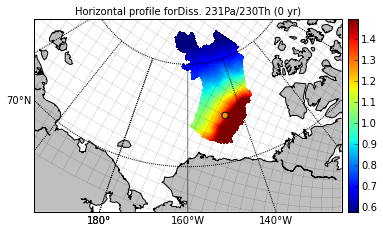

In [46]:
a1=640-400
a2=800-400
b1=0
b2=300
layer=44

data1=readdata('diss','Pa',layer,a1,a2,b1,b2)
data2=readdata('diss','Th',layer,a1,a2,b1,b2)

data=data1[:,:,:]/data2[:,:,:]

vmax=0.7*(data1[:,:,:]/data2[:,:,:]).max()
vmin=1.2*(data1[:,:,:]/data2[:,:,:]).min()

plot_ratio('Diss','231Pa/230Th',data)

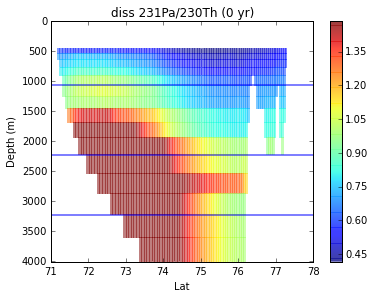

In [49]:
#plot vertical profiles
data1=readdata('diss','Pa',i=0,a1=700-400,a2=701-400,b1=150,b2=250)
data2=readdata('diss','Th',i=0,a1=700-400,a2=701-400,b1=150,b2=250)
data=data1[:]/data2[:]

vmax=0.6*(data[:]).max()
vmin=1.2*(data[:]).min()

plot_vertical(lat=lat[700-400,150:250],data1=data, title1='diss 231Pa/230Th',vmin=vmin,vmax=vmax)

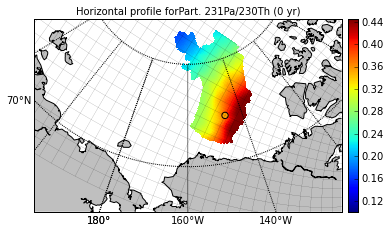

In [53]:
data1=readdata('part','Pa',layer,a1,a2,b1,b2)
data2=readdata('part','Th',layer,a1,a2,b1,b2)


data=data1/data2
vmax=0.8*(data).max()
vmin=1*(data).min()


plot_ratio('Part','231Pa/230Th',data)
plt.show()

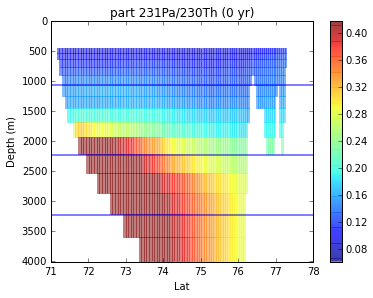

In [56]:
#plot vertical profiles
data1=readdata('part','Pa',i=0,a1=700-400,a2=701-400,b1=150,b2=250)
data2=readdata('part','Th',i=0,a1=700-400,a2=701-400,b1=150,b2=250)
data=data1[:]/data2[:]

vmax=0.8*(data[:]).max()
vmin=1*(data[:]).min()

plot_vertical(lat=lat[700-400,150:250],data1=data, title1='part 231Pa/230Th',vmin=vmin,vmax=vmax)

## Ice (Useful in understanding the tracer profiles below)

1.00962


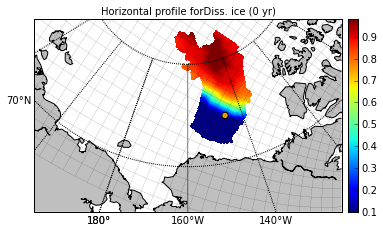

In [60]:
#plot ice profiles
data=readice('icePa',layer,a1,a2,b1,b2)

vmax=0.98#*(data[:,:,:]).max()
vmin=1*(data[:,:,:]).min()+0.1

print data[:,:,:].max()

plot_ratio('Diss','ice',data)

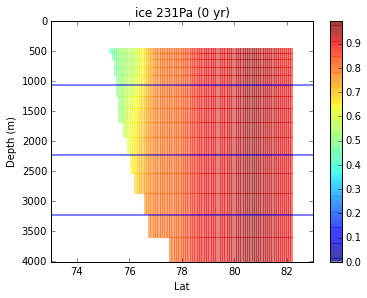

In [73]:
data=readice('icePa',i=0,a1=720-400-50,a2=721-400-50,b1=150,b2=250)

vmax=1*(data[:]).max()
vmin=1.2*(data[:]).min()

plot_vertical(lat=lat[700-400-50,150:250],data1=data, title1='ice 231Pa',vmin=vmin,vmax=vmax)

1.00962


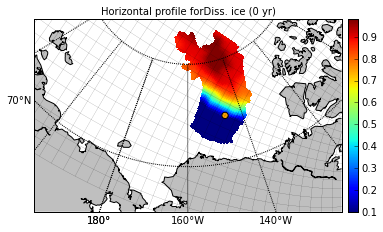

In [65]:
data=readice('iceTh',layer,a1,a2,b1,b2)

vmax=0.98#*(data[:,:,:]).max()
vmin=1*(data[:,:,:]).min()+0.1

print data[:,:,:].max()

plot_ratio('Diss','ice',data)

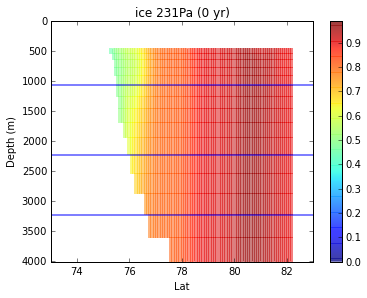

In [74]:
data=readice('iceTh',i=0,a1=720-400-50,a2=721-400-50,b1=150,b2=250)

vmax=1*(data[:]).max()
vmin=1.2*(data[:]).min()

plot_vertical(lat=lat[700-400-50,150:250],data1=data, title1='ice 231Pa',vmin=vmin,vmax=vmax)

In [75]:
data=ptrc.variables['TR_11'][:,:,:,:]

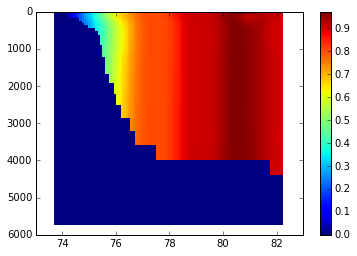

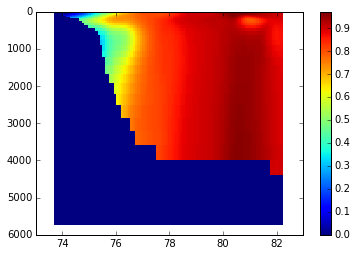

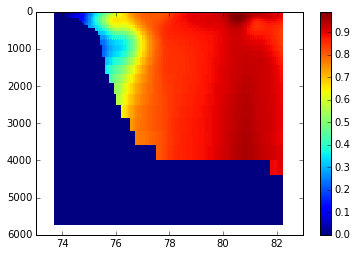

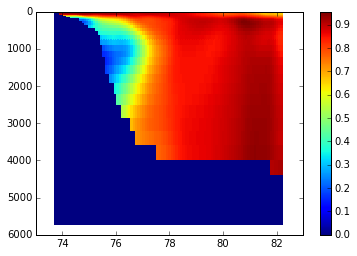

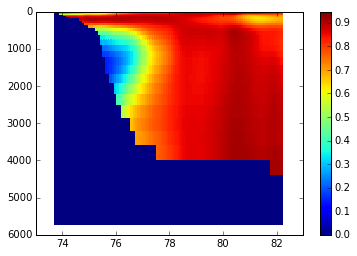

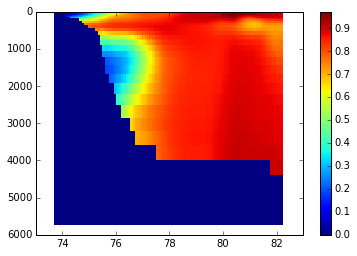

In [85]:
plt.pcolor(lat[700-400-50,150:250],dep[:],data[0,:,720-400-50,150:250])
plt.gca().invert_yaxis();plt.colorbar()
plt.show()

plt.pcolor(lat[700-400-50,150:250],dep[:],data[3,:,720-400-50,150:250])
plt.gca().invert_yaxis();plt.colorbar()
plt.show()

plt.pcolor(lat[700-400-50,150:250],dep[:],data[6,:,720-400-50,150:250])
plt.gca().invert_yaxis();plt.colorbar()
plt.show()
plt.pcolor(lat[700-400-50,150:250],dep[:],data[9,:,720-400-50,150:250])
plt.gca().invert_yaxis();plt.colorbar()
plt.show()
plt.pcolor(lat[700-400-50,150:250],dep[:],data[12,:,720-400-50,150:250])
plt.gca().invert_yaxis();plt.colorbar()
plt.show()
plt.pcolor(lat[700-400-50,150:250],dep[:],data[15,:,720-400-50,150:250])
plt.gca().invert_yaxis();plt.colorbar()
plt.show()